In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import time
import datetime
from sklearn.metrics import roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.cross_validation import KFold, cross_val_score
import xgboost as xgb
#Settings
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', 100)

In [11]:
raw_email = pd.read_csv('~/PYTHON/hackerrank/predict_email/training_dataset_2.csv')
test_email = pd.read_csv('~/PYTHON/hackerrank/predict_email/test_dataset.csv')
# print(raw_email.shape)
# print(test_email.shape)

In [12]:
#functions
def binary_output(x):
    if x ==False:
        return 0
    elif x == True:
        return 1
    else:
        return x

def weekend_binary(x):
    time_obj = time.gmtime(int(x))
    if time_obj.tm_wday > 4:
        return 1
    else:
        return 0

def month_label(x):
    month_dict = {1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'}
    time_obj = time.gmtime(x).tm_mon
    return month_dict[time_obj]

def hour_of_day_label(x):
    hour_dict = {}
    for i in range(0,25):
        hour_dict[i] = '{}_oclock'.format(i)
    time_obj = time.gmtime(x).tm_hour
    return hour_dict[time_obj]

def days_online_sent(row):
    sent = datetime.datetime.utcfromtimestamp(row['sent_time_with_timezone'])
    online = datetime.datetime.utcfromtimestamp(row['last_online_with_timezone'])
    days_online = sent - online
    return days_online.days

def days_existence_sent(row):
    sent = datetime.datetime.utcfromtimestamp(row['sent_time_with_timezone'])
    created = datetime.datetime.utcfromtimestamp(row['hacker_created_at_with_timezone'])
    existence_sent = sent - created
    return existence_sent.days

# Normalising Functions
def normalise_contest_login(df):
    cols = ['contest_login_count_1_days','contest_login_count_7_days','contest_login_count_30_days',
            'contest_login_count_365_days','contest_login_count']
    norm_cols = ['norm_contest_login_0_1', 'norm_contest_login_1_7','norm_contest_login_7_30',
                 'norm_contest_login_30_365','norm_contest_login_365_more']
    data = df[cols]
    norm_data = pd.DataFrame(columns=norm_cols)
    norm_data[norm_cols[0]] = (data[cols[0]]) / data[cols[4]] #0-1
    norm_data[norm_cols[1]] = (data[cols[1]] - data[cols[0]]) / data[cols[4]] #1-7
    norm_data[norm_cols[2]] = (data[cols[2]] - data[cols[1]]) / data[cols[4]] #7-30
    norm_data[norm_cols[3]] = (data[cols[3]] - data[cols[2]]) / data[cols[4]] #30-365
    norm_data[norm_cols[4]] = (data[cols[4]] - data[cols[3]]) / data[cols[4]] #365 more
    norm_data[norm_data.isnull()==True] = int(0)
    return norm_data

def normalise_contest_participation(df):
    cols = ['contest_participation_count_1_days','contest_participation_count_7_days','contest_participation_count_30_days',
            'contest_participation_count_365_days','contest_participation_count']
    norm_cols = ['norm_contest_participation_0_1', 'norm_contest_participation_1_7','norm_contest_participation_7_30',
                 'norm_contest_participation_30_365','norm_contest_participation_365_more']
    data = df[cols]
    norm_data = pd.DataFrame(columns=norm_cols)
    norm_data[norm_cols[0]] = (data[cols[0]]) / data[cols[4]] #0-1
    norm_data[norm_cols[1]] = (data[cols[1]] - data[cols[0]]) / data[cols[4]] #1-7
    norm_data[norm_cols[2]] = (data[cols[2]] - data[cols[1]]) / data[cols[4]] #7-30
    norm_data[norm_cols[3]] = (data[cols[3]] - data[cols[2]]) / data[cols[4]] #30-365
    norm_data[norm_cols[4]] = (data[cols[4]] - data[cols[3]]) / data[cols[4]] #365 more
    norm_data[norm_data.isnull()==True] = int(0)
    return norm_data

def normalise_ipn_count(df):
    cols = ['ipn_count_1_days','ipn_count_7_days','ipn_count_30_days',
            'ipn_count_365_days','ipn_count']
    norm_cols = ['norm_ipn_count_0_1', 'norm_ipn_count_1_7','norm_ipn_count_7_30',
                 'norm_ipn_count_30_365','norm_ipn_count_365_more']
    data = df[cols]
    norm_data = pd.DataFrame(columns=norm_cols)
    norm_data[norm_cols[0]] = (data[cols[0]]) / data[cols[4]] #0-1
    norm_data[norm_cols[1]] = (data[cols[1]] - data[cols[0]]) / data[cols[4]] #1-7
    norm_data[norm_cols[2]] = (data[cols[2]] - data[cols[1]]) / data[cols[4]] #7-30
    norm_data[norm_cols[3]] = (data[cols[3]] - data[cols[2]]) / data[cols[4]] #30-365
    norm_data[norm_cols[4]] = (data[cols[4]] - data[cols[3]]) / data[cols[4]] #365 more
    norm_data[norm_data.isnull()==True] = int(0)
    return norm_data

def normalise_ipn_read(df):
    cols = ['ipn_read_1_days','ipn_read_7_days','ipn_read_30_days',
            'ipn_read_365_days','ipn_read']
    norm_cols = ['norm_ipn_read_0_1', 'norm_ipn_read_1_7','norm_ipn_read_7_30',
                 'norm_ipn_read_30_365','norm_ipn_read_365_more']
    data = df[cols]
    norm_data = pd.DataFrame(columns=norm_cols)
    norm_data[norm_cols[0]] = (data[cols[0]]) / data[cols[4]] #0-1
    norm_data[norm_cols[1]] = (data[cols[1]] - data[cols[0]]) / data[cols[4]] #1-7
    norm_data[norm_cols[2]] = (data[cols[2]] - data[cols[1]]) / data[cols[4]] #7-30
    norm_data[norm_cols[3]] = (data[cols[3]] - data[cols[2]]) / data[cols[4]] #30-365
    norm_data[norm_cols[4]] = (data[cols[4]] - data[cols[3]]) / data[cols[4]] #365 more
    norm_data[norm_data.isnull()==True] = int(0)
    return norm_data

def normalise_submissions_count(df):
    cols = ['submissions_count_1_days','submissions_count_7_days','submissions_count_30_days',
            'submissions_count_365_days','submissions_count']
    norm_cols = ['norm_submissions_count_0_1', 'norm_submissions_count_1_7','norm_submissions_count_7_30',
                 'norm_submissions_count_30_365','norm_submissions_count_365_more']
    data = df[cols]
    norm_data = pd.DataFrame(columns=norm_cols)
    norm_data[norm_cols[0]] = (data[cols[0]]) / data[cols[4]] #0-1
    norm_data[norm_cols[1]] = (data[cols[1]] - data[cols[0]]) / data[cols[4]] #1-7
    norm_data[norm_cols[2]] = (data[cols[2]] - data[cols[1]]) / data[cols[4]] #7-30
    norm_data[norm_cols[3]] = (data[cols[3]] - data[cols[2]]) / data[cols[4]] #30-365
    norm_data[norm_cols[4]] = (data[cols[4]] - data[cols[3]]) / data[cols[4]] #365 more
    norm_data[norm_data.isnull()==True] = int(0)
    return norm_data

def normalise_submissions_count_contest(df):
    cols = ['submissions_count_contest_1_days','submissions_count_contest_7_days','submissions_count_contest_30_days',
            'submissions_count_contest_365_days','submissions_count_contest']
    norm_cols = ['norm_submissions_count_contest_0_1', 'norm_submissions_count_contest_1_7','norm_submissions_count_contest_7_30',
                 'norm_submissions_count_contest_30_365','norm_submissions_count_contest_365_more']
    data = df[cols]
    norm_data = pd.DataFrame(columns=norm_cols)
    norm_data[norm_cols[0]] = (data[cols[0]]) / data[cols[4]] #0-1
    norm_data[norm_cols[1]] = (data[cols[1]] - data[cols[0]]) / data[cols[4]] #1-7
    norm_data[norm_cols[2]] = (data[cols[2]] - data[cols[1]]) / data[cols[4]] #7-30
    norm_data[norm_cols[3]] = (data[cols[3]] - data[cols[2]]) / data[cols[4]] #30-365
    norm_data[norm_cols[4]] = (data[cols[4]] - data[cols[3]]) / data[cols[4]] #365 more
    norm_data[norm_data.isnull()==True] = int(0)
    return norm_data

def normalise_submissions_count_master(df):
    cols = ['submissions_count_master_1_days','submissions_count_master_7_days','submissions_count_master_30_days',
            'submissions_count_master_365_days','submissions_count_master']
    norm_cols = ['norm_submissions_count_master_0_1', 'norm_submissions_count_master_1_7','norm_submissions_count_master_7_30',
                 'norm_submissions_count_master_30_365','norm_submissions_count_master_365_more']
    data = df[cols]
    norm_data = pd.DataFrame(columns=norm_cols)
    norm_data[norm_cols[0]] = (data[cols[0]]) / data[cols[4]] #0-1
    norm_data[norm_cols[1]] = (data[cols[1]] - data[cols[0]]) / data[cols[4]] #1-7
    norm_data[norm_cols[2]] = (data[cols[2]] - data[cols[1]]) / data[cols[4]] #7-30
    norm_data[norm_cols[3]] = (data[cols[3]] - data[cols[2]]) / data[cols[4]] #30-365
    norm_data[norm_cols[4]] = (data[cols[4]] - data[cols[3]]) / data[cols[4]] #365 more
    norm_data[norm_data.isnull()==True] = int(0)
    return norm_data

def normalise_forum_count(df):
    cols = ['forum_comments_count', 'forum_expert_count', 'forum_questions_count','forum_count']
    norm_cols = ['norm_forum_comments_count','norm_forum_expert_count', 'norm_forum_questions_count']
    data = df[cols]
    norm_data = pd.DataFrame(columns=norm_cols)
    norm_data[norm_cols[0]] = (data[cols[0]]) / data[cols[3]] # comments
    norm_data[norm_cols[1]] = (data[cols[1]]) / data[cols[3]] # expert comment
    norm_data[norm_cols[2]] = (data[cols[2]]) / data[cols[3]] # questions
    norm_data[norm_data.isnull()==True] = int(0)
    return norm_data

def norm_ting(df):
    df_max = max(df)
    df = df/df_max
    return df

In [13]:
def clean_data(df, kind):
    # Feature Extraction
    #Target variable creation for binary outputs
    if kind=='train':
        df['opened_binary'] = df.opened.apply(binary_output)

    #sent time and weekend binary features
    df.hacker_timezone = df.hacker_timezone.fillna(0)
    df['sent_time_with_timezone'] = df.sent_time + df.hacker_timezone
    df['weekend_binary'] = df['sent_time_with_timezone'].apply(weekend_binary)

    #hour of day email sent
    df['hour_of_day'] = df.sent_time_with_timezone.apply(hour_of_day_label)

    #hacker confirmation
    df['hacker_confirmation_binary'] = df.hacker_confirmation.apply(binary_output)

    #number of days between last online and sent variable (in days to match the other variables in the dataset) 
    df.last_online = raw_email.last_online.fillna(0)
    df['last_online_with_timezone'] = df.last_online + raw_email.hacker_timezone
    df['days_since_online_and_sent'] = df.apply(days_online_sent, axis=1)
    df['days_since_online_and_sent'][df['days_since_online_and_sent']<0] = 0
    df['days_since_online_and_sent'][df['days_since_online_and_sent']>1000] = 1000 # from above analysis
    
    df.hacker_created_at = df.hacker_created_at.fillna(0)
    df['hacker_created_at_with_timezone'] = df.hacker_created_at + df.hacker_timezone
    df['days_since_existence'] = df.apply(days_existence_sent, axis=1)
    
    to_norm = ['forum_comments_count', 'forum_expert_count', 'forum_questions_count','forum_count',
               'submissions_count_master_1_days','submissions_count_master_7_days','submissions_count_master_30_days',
               'submissions_count_master_365_days','submissions_count_master',
               'submissions_count_contest_1_days','submissions_count_contest_7_days','submissions_count_contest_30_days',
               'submissions_count_contest_365_days','submissions_count_contest',
               'submissions_count_1_days','submissions_count_7_days','submissions_count_30_days',
               'submissions_count_365_days','submissions_count',
               'ipn_count_1_days','ipn_count_7_days','ipn_count_30_days',
               'ipn_count_365_days','ipn_count',
               'contest_login_count_1_days','contest_login_count_7_days','contest_login_count_30_days',
               'contest_login_count_365_days','contest_login_count',
               'contest_participation_count_1_days','contest_participation_count_7_days','contest_participation_count_30_days',
               'contest_participation_count_365_days','contest_participation_count']
    for i in to_norm:
        df[i] = norm_ting(df[i])
    
    
    norm_contest_login_df = normalise_contest_login(df)
    norm_contest_participation_df = normalise_contest_participation(df)
    norm_ipn_count_df = normalise_ipn_count(df)
    norm_ipn_read_df = normalise_ipn_read(df)
    norm_submissions_count_df = normalise_submissions_count(df)
    norm_submissions_count_contest_df = normalise_submissions_count_contest(df)
    norm_submissions_count_master_df = normalise_submissions_count_master(df)
    norm_forum_count_df = normalise_forum_count(df)
    
    df['days_since_online_and_sent'] = (df['days_since_online_and_sent']) / (max(df['days_since_online_and_sent']))
    df['days_since_existence'] = (df['days_since_existence']) / (max(df['days_since_existence']))
    
    mail_cat_dummies = pd.get_dummies(df.mail_category, prefix='dummy')
    mail_type_dummies = pd.get_dummies(df.mail_type, prefix='dummy')
    hour_dummies = pd.get_dummies(df['hour_of_day'], prefix='dummy')
    
    if kind=='train':
        training_cols = ['weekend_binary',
                         'days_since_online_and_sent',
                         'days_since_existence',
                         'hacker_confirmation_binary','forum_comments_count', 'forum_expert_count', 'forum_questions_count','forum_count',
               'submissions_count_master_1_days','submissions_count_master_7_days','submissions_count_master_30_days',
               'submissions_count_master_365_days','submissions_count_master',
               'submissions_count_contest_1_days','submissions_count_contest_7_days','submissions_count_contest_30_days',
               'submissions_count_contest_365_days','submissions_count_contest',
               'submissions_count_1_days','submissions_count_7_days','submissions_count_30_days',
               'submissions_count_365_days','submissions_count',
               'ipn_count_1_days','ipn_count_7_days','ipn_count_30_days',
               'ipn_count_365_days','ipn_count',
               'contest_login_count_1_days','contest_login_count_7_days','contest_login_count_30_days',
               'contest_login_count_365_days','contest_login_count',
               'contest_participation_count_1_days','contest_participation_count_7_days','contest_participation_count_30_days',
               'contest_participation_count_365_days','contest_participation_count',
                         'opened_binary']
    elif kind=='test':
        training_cols = ['weekend_binary',
                         'days_since_online_and_sent',
                         'days_since_existence',
                         'hacker_confirmation_binary','forum_comments_count', 'forum_expert_count', 'forum_questions_count','forum_count',
               'submissions_count_master_1_days','submissions_count_master_7_days','submissions_count_master_30_days',
               'submissions_count_master_365_days','submissions_count_master',
               'submissions_count_contest_1_days','submissions_count_contest_7_days','submissions_count_contest_30_days',
               'submissions_count_contest_365_days','submissions_count_contest',
               'submissions_count_1_days','submissions_count_7_days','submissions_count_30_days',
               'submissions_count_365_days','submissions_count',
               'ipn_count_1_days','ipn_count_7_days','ipn_count_30_days',
               'ipn_count_365_days','ipn_count',
               'contest_login_count_1_days','contest_login_count_7_days','contest_login_count_30_days',
               'contest_login_count_365_days','contest_login_count',
               'contest_participation_count_1_days','contest_participation_count_7_days','contest_participation_count_30_days',
               'contest_participation_count_365_days','contest_participation_count']
    all_data_ = [norm_contest_login_df, norm_contest_participation_df, norm_ipn_count_df, norm_ipn_read_df,
                norm_submissions_count_df, norm_submissions_count_contest_df, norm_submissions_count_master_df,
                norm_forum_count_df, mail_cat_dummies , mail_type_dummies, hour_dummies,
                df[training_cols]]
    
    all_data = [norm_contest_login_df, norm_contest_participation_df, norm_ipn_count_df, norm_ipn_read_df,
                norm_submissions_count_df, norm_submissions_count_contest_df, norm_submissions_count_master_df,
                norm_forum_count_df, mail_cat_dummies , mail_type_dummies, hour_dummies,
                df[training_cols]]
    
    data = pd.concat(all_data,axis=1)
    data.fillna(0)
    return data

train_data = clean_data(raw_email,'train')
test_data = clean_data(test_email,'test')
test_data = test_data.fillna(0)
#train_data.head(3)
#test_data.head(3)

In [14]:
# print(train_data.shape)
# print(test_data.shape)
# print(train_data[test_data.columns].shape)

In [15]:
def train_model(df1,df2,sample_size=0.05,threshold=0.5):
    data_groups = df1.groupby(['opened_binary',
                              'dummy_mail_type_1',
                              'dummy_mail_type_2',
                              'dummy_mail_type_3',
                              'dummy_mail_type_4'])
    data_groups_ = df1.groupby(['opened_binary',])
    idx_sample = []
    for i, j in data_groups.groups.items():
        for idx in range(int(len(j)*sample_size)):
            idx_sample.append(j[idx])
    
    #sample_data = df1.iloc[idx_sample,:]
    sample_data = df1.iloc[np.random.permutation(len(df1)),:]
    sample_data = sample_data.reset_index(drop=True)
    sample_target = sample_data['opened_binary']
    sample_data = sample_data[df2.columns]
    
    scores = []
    models_used = ['rf_model','lg_model','xgb_model']#,'svm_model']
    models_used_probs = []
    model_probs = pd.DataFrame(columns=models_used)
    
    #ensembling
    rf2_model = RandomForestClassifier(n_estimators=100,min_samples_leaf=5,min_samples_split=1)
    rf2_model.fit(sample_data, sample_target)
    rf_probs = rf2_model.predict_proba(df2)[:,1]
    models_used_probs.append(rf_probs)
    
    lr_model = LogisticRegression()
    lr_model.fit(sample_data, sample_target)
    lr_probs = lr_model.predict_proba(df2)[:,1]
    models_used_probs.append(lr_probs)
    
    xgb_model = xgb.XGBClassifier(max_depth=3, n_estimators=100, learning_rate=0.01)
    xgb_model.fit(sample_data, sample_target)
    xgb_probs = xgb_model.predict_proba(df2)[:,1]
    models_used_probs.append(xgb_probs)
    
#     svm_model = SVC(C=0.01)
#     svm_model.fit(sample_data, sample_target)
#     svm_probs = svm_model.predict_proba(df2)[:,1]
#     models_used_probs.append(svm_probs)
    
    for idx in range(len(models_used)):
        model_probs[models_used[idx]] = models_used_probs[idx]
    
    model_probs['average_score'] = model_probs[models_used].sum(axis=1) / len(models_used)
    
    ensemble_res = []
    for res in  model_probs.average_score.tolist():
        if res > threshold:
            ensemble_res.append(1)
        else:
            ensemble_res.append(0)
    
    return ensemble_res #xgb_model #rf2_model #svm_model #lr_model #rf2_model


In [ ]:
predictions = train_model(train_data,test_data,sample_size=0.33, threshold=0.4)
print(len(predictions))
print(len([i for i in predictions if i == 1]))
print(len([i for i in predictions if i == 0]))
print(((len([i for i in predictions if i == 1])) / (len([i for i in predictions if i == 1]) + len([i for i in predictions if i == 0]))))

In [ ]:
# predictions = model.predict(test_data)

In [ ]:
pred_df = pd.DataFrame(predictions, columns=['predictions'])
pred_df.to_csv('~/PYTHON/hackerrank/predict_email/prediction.csv',header=False,index=False)

Below is a graph to show why I decided to assign people above 1000 to 1000. The curve plateaus at 1000 and sharply dips arond 17,000. These outliers would skew the data and so I chose to limit the range to where maximum information gain was achieved.

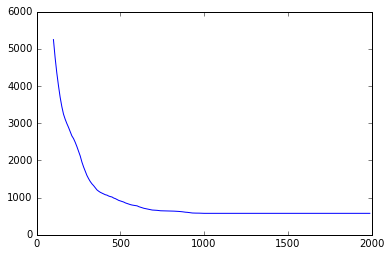

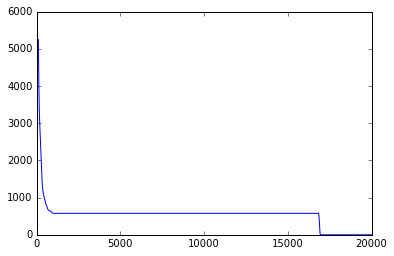

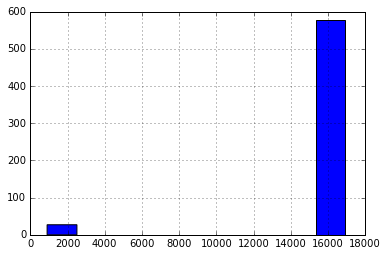

In [14]:
# #days online threshold analysis
# x_values = range(100,2000, 10)
# y_values = [(len(raw_email['days_since_online_and_sent'][raw_email['days_since_online_and_sent']>x])) for x in x_values]
# plt.plot(x_values,y_values)
# plt.show()
# x_values = range(100,20000, 10)
# y_values = [(len(raw_email['days_since_online_and_sent'][raw_email['days_since_online_and_sent']>x])) for x in x_values]
# plt.plot(x_values,y_values)
# plt.show()
# raw_email['days_since_online_and_sent'][raw_email['days_since_online_and_sent']>900].hist()
# plt.show()

Below I assessed different classification models. After finding the best one, I used a gridsearch to find the optimal parameters and used it within my functions for predicting the test set due to the model being more generalised


In [49]:
# # Logistic Regression

# from sklearn.linear_model import LogisticRegression
# from sklearn.cross_validation import KFold, cross_val_score

# lr_model = LogisticRegression()
# lr_model.fit(train_data.iloc[:,:-1], train_data['opened_binary'])
# lr_model.score(train_data.iloc[:,:-1], train_data['opened_binary'])

# #kf = KFold(len(train_data),n_folds=10, shuffle=True, random_state=123)
# #cross_val_score(lr_model, train_data.iloc[:,:-1], train_data['opened_binary'], cv=kf)

0.66973426492856669

In [50]:
# # Support Vector Machines

# from sklearn.svm import LinearSVC
# from sklearn.cross_validation import KFold, cross_val_score

# svm_model = LinearSVC(C=0.01)
# svm_model.fit(train_data.iloc[:,:-1], train_data['opened_binary'])
# svm_model.score(train_data.iloc[:,:-1], train_data['opened_binary'])

# # kf = KFold(len(train_data),n_folds=10, shuffle=True, random_state=123)
# # cross_val_score(svm_model, train_data.iloc[:,:-1], train_data['opened_binary'], cv=kf)

0.66930632365527687

In [56]:
# # Random Forest Classifier

# from sklearn.ensemble import RandomForestClassifier
# from sklearn.cross_validation import KFold, cross_val_score

# rf_model = RandomForestClassifier(n_estimators=100)
# rf_model.fit(train_data.iloc[:,:-1], train_data['opened_binary'])
# rf_model.score(train_data.iloc[:,:-1], train_data['opened_binary'])

# # kf = KFold(len(new_sample_data),n_folds=10, shuffle=True, random_state=123)
# # cross_val_score(rf_model, new_sample_data.iloc[:,:-1], new_sample_data['opened_binary'], cv=kf)

0.97803509118440979

In [51]:
# #Ada Boost Classifier

# from sklearn.ensemble import AdaBoostClassifier
# from sklearn.cross_validation import KFold, cross_val_score

# boost_model = AdaBoostClassifier(n_estimators=100)
# boost_model.fit(train_data.iloc[:,:-1], train_data['opened_binary'])
# boost_model.score(train_data.iloc[:,:-1], train_data['opened_binary'])

# # kf = KFold(len(new_sample_data),n_folds=10, shuffle=True, random_state=123)
# # cross_val_score(boost_model, new_sample_data.iloc[:,:-1], new_sample_data['opened_binary'], cv=kf)

0.67183488050562912

In [ ]:
# from sklearn.grid_search import GridSearchCV

# param_grid = {'min_samples_leaf': [1,2,3,4,5],
#              'min_samples_split':[1,2,3,4]}
# grid = GridSearchCV(rf_model, param_grid, cv=5)
# grid.fit(new_sample_data.iloc[:,:-1], new_sample_data['opened_binary'])
# grid.best_params_

In [53]:
# # Improved rf_model -> rf_model_2
# # Random Forest Classifier

# from sklearn.ensemble import RandomForestClassifier
# from sklearn.cross_validation import KFold, cross_val_score

# rf2_model = RandomForestClassifier(n_estimators=100,min_samples_leaf=5,min_samples_split=1)
# rf2_model.fit(train_data.iloc[:,:-1], train_data['opened_binary'])
# rf2_model.score(train_data.iloc[:,:-1], train_data['opened_binary'])

# #kf = KFold(len(new_sample_data),n_folds=10, shuffle=True, random_state=123)
# #cross_val_score(rf2_model, new_sample_data.iloc[:,:-1], new_sample_data['opened_binary'], cv=kf)

0.78983557179537822

In [54]:
# # ROC Curve values

# from sklearn.metrics import roc_curve

# lr_probs = lr_model.predict_proba(train_data.iloc[:,:-1])[:,1]
# rf2_probs = rf2_model.predict_proba(train_data.iloc[:,:-1])[:,1]
# boost_probs = boost_model.predict_proba(train_data.iloc[:,:-1])[:,1]

# lr_fpr, lr_tpr, lr_thresholds = roc_curve(train_data['opened_binary'],lr_probs)
# rf2_fpr, rf2_tpr, rf2_thresholds = roc_curve(train_data['opened_binary'],rf2_probs)
# boost_fpr, boost_tpr, boost_thresholds = roc_curve(train_data['opened_binary'],boost_probs)

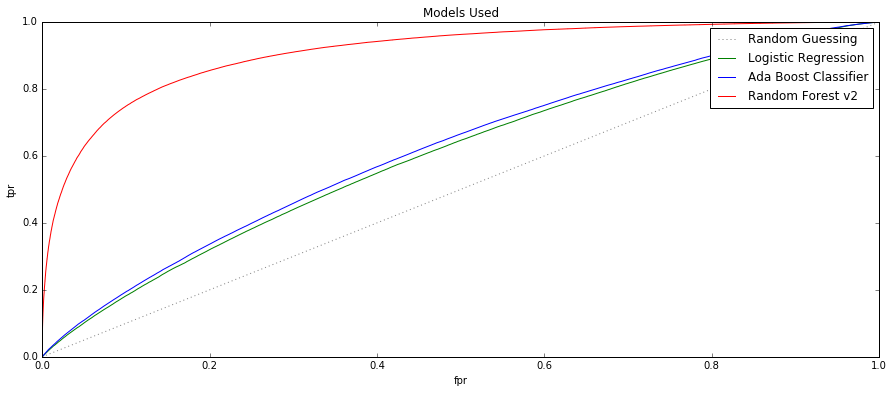

In [55]:
# # ROC Plots

# plt.figure(figsize=(15,6))
# plt.xlim([-0., 1.])
# plt.ylim([0, 1.])
# plt.title('Models Used')
# plt.xlabel('fpr')
# plt.ylabel('tpr')
# plt.plot([0,1],[0,1], c='grey',ls=':', label='Random Guessing')
# plt.plot(lr_fpr, lr_tpr,c='g',label='Logistic Regression')
# plt.plot(boost_fpr, boost_tpr, c='b',label='Ada Boost Classifier')
# plt.plot(rf2_fpr, rf2_tpr,c='r',label='Random Forest v2')
# plt.legend()
# plt.show()